In [2]:
import torch
import torch.nn as nn
from utils import create_bbox_mask
from torch.utils.data import DataLoader
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
from data_loader.data_loaders import CocoDataset, collate_fn
from model.model import *

BATCH_SIZE = 128
seed = 42
torch.manual_seed(seed)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
model = FeatureSynthesisModel(embed_dim=300)
model = model.to(device)
model.load_state_dict(torch.load('saved/models/word2vec/0831_154110/checkpoint-epoch50.pth')['state_dict'])
model.eval()  # set to evaluation mode







cuda:1


FeatureSynthesisModel(
  (features): Sequential(
    (0): Conv2d(300, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
)

In [3]:
from utils import convert_query_to_tensor, create_bbox_mask, one_hot_embedding
import fasttext, fasttext.util
import numpy as np

In [62]:
train_set = CocoDataset(root='./data/coco', mode='val2017')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)
all_features = torch.load('./data/coco/val2017/features/resnet50_features.pt')
all_img_features = torch.stack(list(all_features.values()))
all_img_ids = np.array(list(all_features.keys()))
all_categories = []
all_bboxes = []
embed_fn = fasttext.load_model('cc.en.300.bin').get_word_vector
query_features = []
queries = None
query_ids = None
index = 0
with torch.no_grad():
    for i, (img_ids, layouts, _) in enumerate(train_loader):
        batch_size = len(img_ids)
        for j in range(batch_size):
            # for k in range(len(layouts[j])): layouts[j][k]['category'] = 'beer'
            canvas_tensor = convert_query_to_tensor(layouts[j], 300, mode='word2vec', embedding_fn=embed_fn)
            canvas_tensor = canvas_tensor.to(device)
            output_feature = model(canvas_tensor)
            masks = torch.stack([create_bbox_mask(layouts[j][k]['bbox'], 7) for k in range(len(layouts[j]))]).unsqueeze(1).to(device)
            # normalize the output feature
            output_feature = output_feature / torch.norm(output_feature, dim=1, keepdim=True)
            output_feature = output_feature * masks
            output_feature, _ = torch.max(output_feature, dim=0)
            query_features.append(output_feature.view(1, -1).cpu().numpy())
        
        if i == index: 
            query_features = np.concatenate(query_features, axis=0)
            queries = layouts
            query_ids = img_ids
            break
        # imgs = imgs.to(device)
        # img_features = backbone_model(imgs)
        # all_img_features.append(img_features.cpu().detach())
        # all_img_ids.extend(queries[3])
        # all_categories.extend(queries[0])
        # all_bboxes.extend(queries[1])

print(all_img_features.shape)

torch.Size([5000, 2048, 7, 7])


In [5]:
from pycocotools.coco import COCO
coco = COCO('./data/coco/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(all_img_features.view(len(all_img_features), -1).numpy())
distances, indices = nbrs.kneighbors(query_features)

[[   1 4467 2725 ... 1312 1229 4227]
 [2210 1177  652 ...  874  972 4021]
 [1292  672  916 ... 4532 1123  729]
 ...
 [4393 2541 2332 ... 1997 3053  419]
 [2444  471 1734 ... 2815  123 1642]
 [1781  123 3709 ... 3894 1074 3234]]


In [63]:
from utils import BatchKNearestNeighbor

nbrs = BatchKNearestNeighbor(batch_size=5000, device=device, mask=True)
nbrs.fit(all_img_features.view(all_img_features.shape[0], -1).numpy())

In [64]:
indices, distances = nbrs.predict(query_features, k=10)


In [8]:
query_idx = 105
masks = torch.stack([create_bbox_mask(layouts[query_idx][k]['bbox'], 7) for k in range(len(layouts[query_idx]))]).unsqueeze(1).to(device)
masks = torch.max(masks, dim=0)[0]
masked_img_features = all_img_features.to(device) * masks
print(masks)
# nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(masked_img_features.view(len(masked_img_features), -1).cpu().numpy())
# distances, indices = nbrs.kneighbors(query_features[query_idx].reshape(1, -1))

tensor([[[0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0.]]], device='cuda:1')


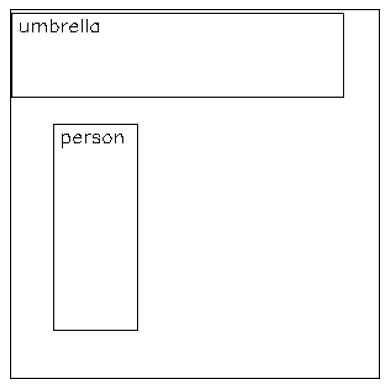

In [56]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

query_idx = 60
# draw a 31 x 31 empty grid
l = 300
grid = np.zeros((l, l, 3))
# draw the bounding box
for i in range(len(queries[query_idx])):
    x, y, w, h = queries[query_idx][i]['bbox']
    x, y, w, h = l * x, l * y, l * w, l * h
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
    cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (1, 1, 1), 1)
    text = f'{queries[query_idx][i]["category"]}'
    cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)

# draw edge around the grid.
grid[0, :, :] = 1
grid[-1, :, :] = 1
grid[:, 0, :] = 1
grid[:, -1, :] = 1

grid = 1 - grid
plt.imshow(grid)
plt.axis('off')
plt.show()



In [21]:
def is_relevant(query_layouts, ranked_img_id, coco):
    img = coco.loadImgs([ranked_img_id])[0]
    ann = coco.loadAnns(coco.getAnnIds(imgIds=[ranked_img_id]))
    ranked_img_layouts = [ann[i] for i in range(len(ann))]
    H, W = img['height'], img['width']
    num_bounding_boxes = len(query_layouts)
    rel_score = 0
    for query_layout in query_layouts:
        # calculate miou
        x1, y1, w1, h1 = query_layout['bbox']
        x1, y1, w1, h1 = x1 * W, y1 * H, w1 * W, h1 * H
        min_x1, min_y1, max_x1, max_y1 = int(x1 - w1 / 2), int(y1 - h1 / 2), math.ceil(x1 + w1 / 2), math.ceil(y1 + h1 / 2)
        query_cat = query_layout['category']
        max_iou = 0
        for ranked_img_layout in ranked_img_layouts:
            if coco.getCatIds(catNms=[query_cat])[0] != ranked_img_layout['category_id']:
                continue
            x2, y2, w2, h2 = ranked_img_layout['bbox']
            min_x2, min_y2, max_x2, max_y2 = int(x2), int(y2), math.ceil(x2 + w2), math.ceil(y2 + h2)
            
            # compute miou
            min_x = max(min_x1, min_x2)
            min_y = max(min_y1, min_y2)
            max_x = min(max_x1, max_x2)
            max_y = min(max_y1, max_y2)
            intersection = max(0, max_x - min_x) * max(0, max_y - min_y)
            union = w1 * h1 + w2 * h2 - intersection
            miou = intersection / union
            max_iou = max(max_iou, miou)
        rel_score += max_iou
    rel_score /= num_bounding_boxes
    print(rel_score)
    return rel_score > 0.3

In [57]:
coco.loadImgs(284743)[0]

{'license': 1,
 'file_name': '000000284743.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000284743.jpg',
 'height': 425,
 'width': 640,
 'date_captured': '2013-11-22 21:17:52',
 'flickr_url': 'http://farm4.staticflickr.com/3348/3449687086_e7e2156c9b_z.jpg',
 'id': 284743}

0.49282787077279966
0.36259627356540125
0.4933682665520256
0.44865974375221584
0.07661457640572795
0.45163309158520204
1.0150383714011757
0.24255806852645978
0.27105387383543417
0.2619269600104421
250137


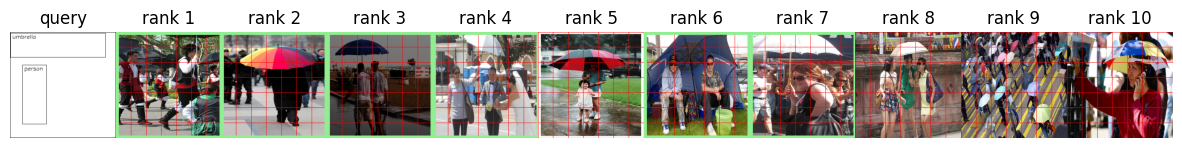

In [57]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# ranked_list = all_img_ids[indices[query_idx]]
ranked_list = all_img_ids[indices[query_idx]]
relevant_positions = [idx for idx, img in enumerate(ranked_list) if is_relevant(queries[query_idx], img, coco=coco)]
# img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]
img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]

# img_path = f'./data/coco/val2017/images/000000221281.jpg'
print(query_ids[query_idx])

TARGET_SIZE = (256, 256)  # Adjust as needed

plt.figure(figsize=(15, 10))

# Display the 'query' image in the first position
plt.subplot(1, 11, 1) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(grid)
plt.axis('off')
plt.title('query')

# Loop through and display 10 result images
for i in range(10):
    plt.subplot(1, 11, i+2) # for 1 row and 11 columns
    img = Image.open(img_paths[i])
    
    # Resize the image to target size
    img = img.resize(TARGET_SIZE, Image.LANCZOS)

    draw = ImageDraw.Draw(img)
    width, height = img.size
    x_spacing = width / 7
    y_spacing = height / 7
    
    # Draw grid lines
    for j in range(8):
        x = int(x_spacing * j)
        draw.line([(x, 0), (x, height)], fill='red')
    for j in range(8):
        y = int(y_spacing * j)
        draw.line([(0, y), (width, y)], fill='red')
    
    # Draw a light green border for relevant positions
    if i in relevant_positions:
        draw.rectangle([(0, 0), (width, height)], outline='lightgreen', width=7)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    # plt.title(f'rank {i+1}, img: {all_img_ids[indices[query_idx][i]]}, distance: {distances[query_idx][i]:.3f}')
    plt.title(f'rank {i+1}')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()



In [58]:
from torchvision.models import resnet50
import torch.nn as nn
tmp_model = resnet50(pretrained=True)
gap_layer = list(tmp_model.children())[-2]

# Extract the fully connected layer
fc_layer = list(tmp_model.children())[-1]

tmp_feature = query_features[query_idx].reshape(2048, 7, 7)
tmp_feature = torch.from_numpy(tmp_feature).unsqueeze(0)

# Pass the feature through the global average pooling layer
pooled_feature = gap_layer(tmp_feature)
print(pooled_feature.shape)
# Flatten the pooled feature
flattened_feature = pooled_feature.view(pooled_feature.size(0), -1)

# Pass the flattened feature through the fully connected layer
pred = fc_layer(flattened_feature)
print(torch.argmax(pred, dim=1))


/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 2048, 1, 1])
tensor([879])


In [205]:
from torchvision.models import resnet50
from PIL import Image, ImageDraw
import torch, torchvision
import matplotlib.pyplot as plt

model = resnet50(pretrained=True)
img_path = f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][3]]:06}.jpg'
img = Image.open(img_path)
img = torchvision.transforms.Resize((224, 224))(img)
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
model.eval()
pred = model(img_tensor.unsqueeze(0))
print(torch.argmax(pred, dim=1))

tensor([542])


In [54]:
cat_vec = embed_fn('furniture')
vec_1 = embed_fn('dog')

# distance between cat and furniture
np.dot(cat_vec, vec_1) / (np.linalg.norm(cat_vec) * np.linalg.norm(vec_1))

0.52298087

In [89]:
import json
query_path = './data/coco/train/query_.json'
with open(query_path, 'r') as f:
    query = json.load(f)
label_path = './data/coco/labels.txt'
with open(label_path, 'r') as f:
    labels = f.read().split('\n')

count_labels = {}
for q in query:
    label = q['layout']['category']
    if label not in count_labels:
        count_labels[label] = 0
    count_labels[label] += 1
print(count_labels)

{'dining table': 4017, 'teddy bear': 832, 'cake': 664, 'bench': 905, 'person': 24207, 'dog': 1137, 'clock': 219, 'motorcycle': 1085, 'bowl': 1060, 'broccoli': 455, 'chair': 1587, 'apple': 253, 'bed': 1455, 'backpack': 184, 'hot dog': 329, 'elephant': 1047, 'horse': 965, 'fork': 201, 'carrot': 203, 'couch': 1550, 'boat': 629, 'microwave': 123, 'cell phone': 219, 'train': 1398, 'bus': 1172, 'book': 476, 'pizza': 1162, 'knife': 223, 'orange': 314, 'sandwich': 845, 'bird': 560, 'airplane': 1043, 'snowboard': 139, 'tv': 625, 'keyboard': 293, 'mouse': 41, 'umbrella': 781, 'suitcase': 583, 'cat': 1386, 'car': 1058, 'banana': 648, 'cup': 419, 'giraffe': 1296, 'truck': 1017, 'oven': 563, 'potted plant': 522, 'tie': 219, 'bicycle': 482, 'baseball bat': 85, 'spoon': 123, 'zebra': 949, 'bottle': 319, 'surfboard': 375, 'skateboard': 179, 'vase': 405, 'traffic light': 79, 'laptop': 818, 'refrigerator': 640, 'wine glass': 236, 'sink': 360, 'toilet': 757, 'bear': 340, 'parking meter': 108, 'cow': 665,

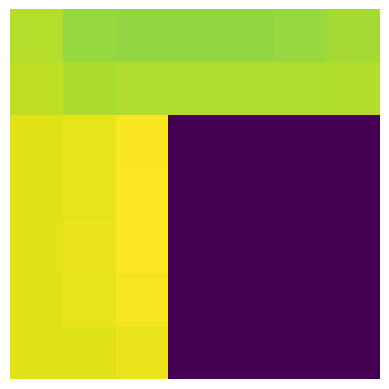

In [59]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

query_idx = 60
query_feature_map = query_features[query_idx].reshape(2048, 7, 7)
gray_scale = np.average(query_feature_map, axis=0)
gray_scale = gray_scale / np.max(gray_scale)

# why is the color of zero value purple?
# gray_scale = gray_scale / np.max(gray_scale)
# gray_scale = gray_scale * 255 
plt.imshow(gray_scale)
plt.axis('off')
plt.show()



250137


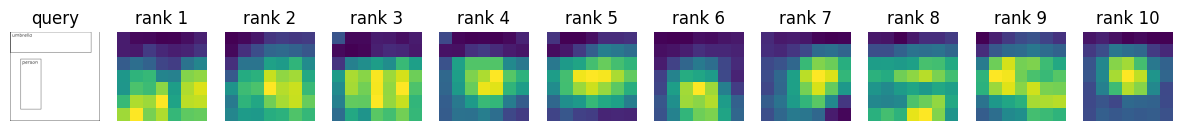

In [65]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

ranked_list = all_img_ids[indices[query_idx]]
feature_maps = all_img_features[indices[query_idx]].view(len(indices[query_idx]), 2048, 7, 7).cpu().numpy()
processed_feature_maps = []
for i, fm in enumerate(feature_maps):
    gray = np.average(fm, axis=0)
    gray = gray / gray.shape[0]
    processed_feature_maps.append(gray)
processed_feature_maps = np.stack(processed_feature_maps, axis=0)

# relevant_positions = [idx for idx, img in enumerate(ranked_list) if is_relevant(queries[query_idx], img, coco=coco)]
# print(is_relevant(queries[query_idx], ranked_list[0], coco=coco))
img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]
# img_path = f'./data/coco/val2017/images/000000221281.jpg'
print(query_ids[query_idx])

plt.figure(figsize=(15, 10))

# Display the 'query' image in the first position
plt.subplot(1, 11, 1) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(grid)
plt.axis('off')
plt.title('query')

# Loop through and display 10 result images
for i in range(10):
    plt.subplot(1, 11, i+2) # for 1 row and 11 columns
    plt.imshow(processed_feature_maps[i])
    plt.axis('off')
    plt.title(f'rank {i+1}')


# for i in range(10):
#     plt.subplot(3, 4, i+2)
#     plt.imshow(processed_feature_maps[i])
#     plt.axis('off')
#     plt.title(f'rank {i+1}, img: {all_img_ids[indices[query_idx][i]]}, distance: {distances[query_idx][i]:.3f}')

plt.show()
